####  Precificando Debenture CDI + 
##### https://data.anbima.com.br/debentures/CSMGA4/caracteristicas
Dados da debenture foram pegos em 2023-08-03, por isso ha fluxos liquidados. Vamos precificar nos baseando na data base abaixo
Data base de calculo 2022-01-2022

In [169]:
import pandas as pd
import numpy as np
from decimal import Decimal
from pandas.tseries.offsets import BDay
from pandas.tseries.offsets import CustomBusinessDay
import itertools

In [170]:
def truncar_casas_decimais(valor, casas):
    multiplicador = 10 ** casas
    return int(valor * multiplicador) / multiplicador

1. Estabelecendo fluxos (pegos do site da Anbima)

In [171]:
# Dados fornecidos
dados = """
16/09/2019	16/09/2019	Pagamento de juros	106,1500 %	R$ 14,627060	LIQUIDADO
16/12/2019	16/12/2019	Pagamento de juros	106,1500 %	R$ 13,669380	LIQUIDADO
16/03/2020	16/03/2020	Pagamento de juros	106,1500 %	R$ 10,870450	LIQUIDADO
15/06/2020	15/06/2020	Pagamento de juros	106,1500 %	R$ 8,513049	LIQUIDADO
15/09/2020	15/09/2020	Pagamento de juros	106,1500 %	R$ 5,654030	LIQUIDADO
15/12/2020	15/12/2020	Pagamento de juros	106,1500 %	R$ 5,007149	LIQUIDADO
15/03/2021	15/03/2021	Pagamento de juros	106,1500 %	R$ 4,768150	LIQUIDADO
15/06/2021	15/06/2021	Pagamento de juros	106,1500 %	R$ 7,705580	AGUARDANDO PU
15/09/2021	15/09/2021	Amortizacao	8,3000 %	R$ 83,000000	LIQUIDADO
15/09/2021	15/09/2021	Pagamento de juros	106,1500 %	R$ 12,274150	LIQUIDADO
15/12/2021	15/12/2021	Amortizacao	9,0513 %	R$ 83,000420	LIQUIDADO
15/12/2021	15/12/2021	Pagamento de juros	106,1500 %	R$ 16,162830	LIQUIDADO
15/03/2022	15/03/2022	Amortizacao	9,9520 %	R$ 82,999638	LIQUIDADO
15/03/2022	15/03/2022	Pagamento de juros	106,1500 %	R$ 20,565820	LIQUIDADO
07/04/2022	07/04/2022	Premio	0,0000%	R$ 1,710089	LIQUIDADO
15/06/2022	15/06/2022	Amortizacao	11,0519 %	R$ 82,999762	LIQUIDADO
15/06/2022	15/06/2022	Pagamento de juros	106,1500 %	R$ 23,429560	LIQUIDADO
15/09/2022	15/09/2022	Amortizacao	12,4251 %	R$ 82,999690	LIQUIDADO
15/09/2022	15/09/2022	Pagamento de juros	106,1500 %	R$ 22,981724	LIQUIDADO
15/12/2022	15/12/2022	Amortizacao	14,1880 %	R$ 82,999869	LIQUIDADO
15/12/2022	15/12/2022	Pagamento de juros	106,1500 %	R$ 19,878720	LIQUIDADO
15/03/2023	15/03/2023	Amortizacao	16,5339 %	R$ 83,000280	LIQUIDADO
15/03/2023	15/03/2023	Pagamento de juros	106,1500 %	R$ 17,058327	LIQUIDADO
15/06/2023	15/06/2023	Amortizacao	19,8091 %	R$ 83,000196	LIQUIDADO
15/06/2023	15/06/2023	Pagamento de juros	106,1500 %	R$ 14,237920	LIQUIDADO
15/09/2023	15/09/2023	Amortizacao	24,7024 %	-	PREVISTO
15/09/2023	15/09/2023	Pagamento de juros	106,1500 %	-	PREVISTO
15/12/2023	15/12/2023	Amortizacao	32,8063 %	-	PREVISTO
15/12/2023	15/12/2023	Pagamento de juros	106,1500 %	-	PREVISTO
15/03/2024	15/03/2024	Amortizacao	48,8235 %	-	PREVISTO
15/03/2024	15/03/2024	Pagamento de juros	106,1500 %	-	PREVISTO
15/06/2024	17/06/2024	Vencimento (resgate)	100,0000 %	-	PREVISTO
15/06/2024	17/06/2024	Pagamento de juros	106,1500 %	-	PREVISTO
"""

In [172]:
# Dividir as linhas em uma lista
linhas = dados.strip().split('\n')

# Dividir os valores em cada linha
dados_formatados = [linha.split('\t') for linha in linhas]

# Criar o DataFrame
df = pd.DataFrame(dados_formatados, columns=["Data do evento", "Data de liquidação", "Evento", "Taxa", "Valor pago", "Status"])

# Converter as colunas de data para o formato datetime
df["Data do evento"] = pd.to_datetime(df["Data do evento"], format='%d/%m/%Y')
df["Data de liquidação"] = pd.to_datetime(df["Data de liquidação"], format='%d/%m/%Y')

# Converter a coluna "Taxa" para taxa dividida por 100
df["Taxa"] = df["Taxa"].str.replace('%', '').str.replace(',', '.').astype(float) / 100

# Converter "-" por 0
df["Valor pago"] = df["Valor pago"].str.replace('-','0')

# Converter a coluna "Valor pago" para formato numérico (float)
df["Valor pago"] = df["Valor pago"].str.strip("R$").str.strip().str.replace(',','.').astype(float)


# Reordenar as colunas
colunas_na_ordem = ["Data do evento", "Data de liquidação", "Evento", "Taxa", "Valor pago", "Status"]
df = df.reindex(columns=colunas_na_ordem)

# Desconsiderando "Premio"
df = df[~(df["Evento"]=="Premio")]

In [173]:
df.head(5)

,Data do evento,Data de liquidação,Evento,Taxa,Valor pago,Status
0,2019-09-16,2019-09-16,Pagamento de juros,1.0615,14.627060,LIQUIDADO
1,2019-12-16,2019-12-16,Pagamento de juros,1.0615,13.669380,LIQUIDADO
2,2020-03-16,2020-03-16,Pagamento de juros,1.0615,10.870450,LIQUIDADO
3,2020-06-15,2020-06-15,Pagamento de juros,1.0615,8.513049,LIQUIDADO
4,2020-09-15,2020-09-15,Pagamento de juros,1.0615,5.654030,LIQUIDADO


In [174]:
data_base = pd.to_datetime("2022-01-20")

2. Demais inputs

In [196]:
# VNA TODO sera input
vna = 833.99958
# PU PAR TODO sera input -> VNA * fator_juros
pu_par = 842.034941
taxa_negocio = 111.2153
taxa_emissao = 106.15
# valor emissao  (sera descontando as amortizacoes) TODO sera input
ve = 1000

In [176]:
# Curva TODO sera input
dados = [
    [pd.to_datetime("2022-03-15"), 10.36],
    [pd.to_datetime("2022-06-15"), 11.39],
    [pd.to_datetime("2022-09-15"), 11.79],
    [pd.to_datetime("2022-12-15"), 11.89],
    [pd.to_datetime("2023-03-15"), 11.86],
    [pd.to_datetime("2023-06-15"), 11.81],
    [pd.to_datetime("2023-09-15"), 11.65],
    [pd.to_datetime("2023-12-15"), 11.46],
    [pd.to_datetime("2024-03-15"), 11.33],
    [pd.to_datetime("2024-06-17"), 11.25]
]

# Criar um DataFrame
colunas = ["Data", "taxa"]
df_curva = pd.DataFrame(dados, columns=colunas)

In [177]:
# Feriados ANBIMA TODO sera input
df_holidays = pd.read_csv("feriados.csv", header=None)
df_holidays[0] = pd.to_datetime(df_holidays[0], format="%d/%m/%Y")

3. Estabelecendo amortizacoes a partir do fluxo total do papel

In [178]:
# Calculando amortizacoes
df_amortizacao = df[df["Evento"].isin(["Amortizacao"])].pivot(index="Data do evento", columns="Evento", values=["Taxa", "Valor pago"])
df_amortizacao = pd.concat([df_amortizacao["Taxa"], df_amortizacao["Valor pago"]], axis = 1)
df_amortizacao.columns = ["Taxa", "Valor pago"]
df_amortizacao = df_amortizacao.reset_index(drop = False)

# Adicionando vencimento
df_vencimento = df[df["Evento"]=="Vencimento (resgate)"][["Data de liquidação", "Taxa"]].rename(columns={"Data de liquidação": "Data do evento"})
df_amortizacao = pd.concat([df_amortizacao,df_vencimento])

lista_pagamento_amortizacao = []
for porcentagem_amortizacao in df_amortizacao["Taxa"].to_list():
    valor_pago = ve * porcentagem_amortizacao
    ve -= valor_pago
    lista_pagamento_amortizacao.append(valor_pago)

In [179]:
# Calculandod diferenca entre dias
# instanciando objeto de feriados
list_holidays = df_holidays[0].to_list()
# [0:-1] para excluir o ultimo dia, ultimas versoes existe o campo inclusive
df_amortizacao["dias_uteis"] = df_amortizacao["Data do evento"].apply(lambda x: len(pd.bdate_range(data_base, x, holidays=list_holidays, freq='C')[0:-1]))
df_amortizacao["amortizacao_calculada"] = lista_pagamento_amortizacao

df_amortizacao = df_amortizacao[df_amortizacao["Data do evento"] >= data_base]

# Cruzando com a curva
df_amortizacao = df_amortizacao.merge(df_curva, left_on = ["Data do evento"], right_on= ["Data"], how = "left")


# Calculando juros projetados
df_amortizacao["dias_uteis_t1"] = df_amortizacao["dias_uteis"].shift(1)
df_amortizacao["taxa_t1"] = df_amortizacao["taxa"].shift(1)

list_juros_projetado = []
amortizacoes_soma = 0
for index, row in df_amortizacao.iterrows():

    if index == 0:
        juros_projetado = (((((((row["taxa"] / 100 + 1) ** (1 / 252) - 1) * taxa_emissao / 100) + 1) ** (row["dias_uteis"]) - 1) * pu_par) + (pu_par - vna))
    else:
        juros_projetado = ((((((((row["taxa"] / 100 + 1) ** (1 / 252) - 1) * taxa_emissao / 100) + 1) ** (
        row["dias_uteis"])) / ((((row["taxa_t1"] / 100 + 1) ** (1 / 252) - 1) * taxa_emissao / 100) + 1) ** (
                             row["dias_uteis_t1"])) - 1) * (vna - amortizacoes_soma))
    amortizacoes_soma += row["amortizacao_calculada"]
    list_juros_projetado.append(juros_projetado)
df_amortizacao["juros_projetado"] = list_juros_projetado

# Truncando juros projetados
df_amortizacao["juros_projetado"] = df_amortizacao["juros_projetado"].apply(lambda x: truncar_casas_decimais(valor=x,casas = 6))


df_amortizacao["fluxo_descontado"] = (((df_amortizacao["amortizacao_calculada"] + df_amortizacao["juros_projetado"]) / (((((df_amortizacao["taxa"] / 100 + 1) ** (1 / 252) - 1) * (taxa_negocio / 100)) + 1) ** df_amortizacao["dias_uteis"])))

In [180]:
pu_mtm = df_amortizacao["fluxo_descontado"].sum()
print(f"pu_mtm: {pu_mtm}")

pu_mtm: 836.638042832487


In [181]:
duration = truncar_casas_decimais(((df_amortizacao['dias_uteis'] * df_amortizacao['fluxo_descontado']).sum())/pu_mtm,2)
print(f"duration: {duration}")

duration: 292.45


4. Comparando com calculadora ANBIMA

In [182]:
# https://data.anbima.com.br/ferramentas/calculadora/debentures/CSMGA4?ativo=debentures

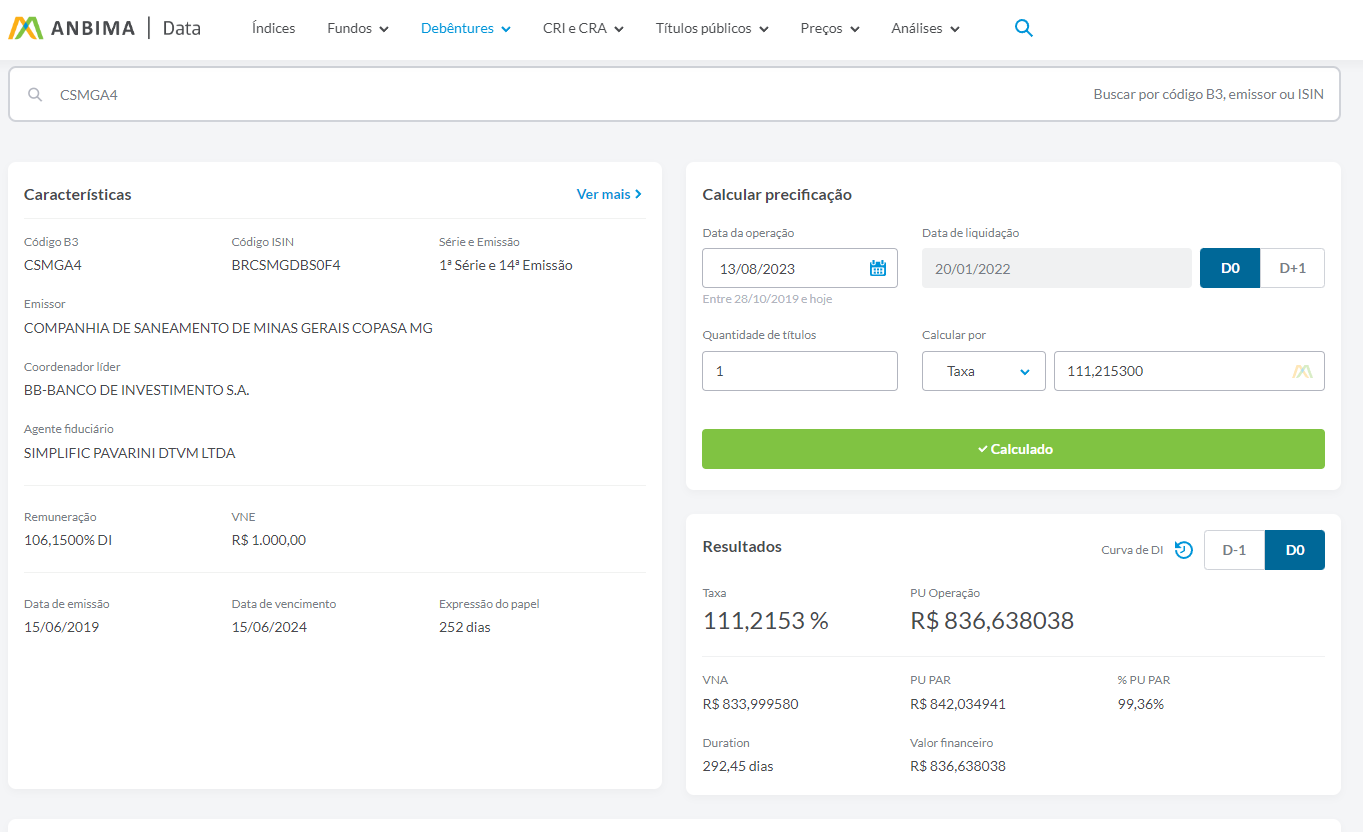

In [183]:
from IPython import display
display.Image("exemplo_debenture.PNG")

In [184]:
# Como chegar no PU PAR? Pegamos o valor pu_par diretamente do site. 
# Porem, para calcular e chegar neste valor devemos pegar o valor de emissao e descontar todas as amortizacoes ate a data de referencia.
# Feito isso, devemos acruar o CDI a partir da ultima data de amortizacao ate a data de referencia



In [185]:
# Pegando cdi entre 2021-12-15 e 2022-01-20
primeira_data = df[(df["Evento"]=="Amortizacao")&(df["Data do evento"]<=data_base)]["Data do evento"].min()
print(f"primeira data: {primeira_data}")
print(f"ultima data: {data_base}")

primeira data: 2021-09-15 00:00:00
ultima data: 2022-01-20 00:00:00


In [186]:
data = [
    ("15/12/2021", 9.15),
    ("16/12/2021", 9.15),
    ("17/12/2021", 9.15),
    ("20/12/2021", 9.15),
    ("21/12/2021", 9.15),
    ("22/12/2021", 9.15),
    ("23/12/2021", 9.15),
    ("24/12/2021", 9.15),
    ("27/12/2021", 9.15),
    ("28/12/2021", 9.15),
    ("29/12/2021", 9.15),
    ("30/12/2021", 9.15),
    ("31/12/2021", 9.15),
    ("03/01/2022", 9.15),
    ("04/01/2022", 9.15),
    ("05/01/2022", 9.15),
    ("06/01/2022", 9.15),
    ("07/01/2022", 9.15),
    ("10/01/2022", 9.15),
    ("11/01/2022", 9.15),
    ("12/01/2022", 9.15),
    ("13/01/2022", 9.15),
    ("14/01/2022", 9.15),
    ("17/01/2022", 9.15),
    ("18/01/2022", 9.15),
    ("19/01/2022", 9.15),
    ("20/01/2022", 9.15)
]

df_cdi = pd.DataFrame(data, columns=["Data", "Taxa"])
df_cdi["Data"] = pd.to_datetime(df_cdi["Data"], format="%d/%m/%Y")
df_cdi["Taxa"] = df_cdi["Taxa"].astype(float)
df_cdi.head(5)


,Data,Taxa
0,2021-12-15,9.15
1,2021-12-16,9.15
2,2021-12-17,9.15
3,2021-12-20,9.15
4,2021-12-21,9.15


In [243]:
df_cdi["fator_diario"] = (1+(df_cdi["Taxa"]/100))**(1/252)
df_cdi["fator_diario_ajustado"] = 1 + ((df_cdi["fator_diario"] - 1)*taxa_emissao/100)
df_cdi["fator_diario_ajustado"] = df_cdi["fator_diario_ajustado"].round(decimals=16) 
# Incluind 1 no primeiro dia
condition = df_cdi.index == 0
df_cdi.loc[condition, "fator_diario_ajustado"] = 1
df_cdi["fator_acumulado"] = df_cdi["fator_diario_ajustado"].cumprod()
fator_acumulado_cdi = df_cdi["fator_acumulado"].max()
print(f"fator acumulado cdi: {fator_acumulado_cdi}")


fator acumulado cdi: 1.0096347956048644


In [244]:
# Chegando no valor desconsiderando ultimas amortizacoes:
amortizacaoes_desconsiderar = df[(df["Data do evento"] <= data_base)&(df["Evento"]=="Amortizacao")]["Valor pago"].sum()
ve = 1000 # valor emissao
pu_par_calculado = (ve - amortizacaoes_desconsiderar) * fator_acumulado_cdi # eh o proprio valor de emissao descontado dos valores pagos acruados os juros da data do ultimo evento ate a data base


In [245]:
print(f"pu par Anbima: {pu_par}")
print(f"pu par calculado: {pu_par_calculado}")

pu par Anbima: 842.034941
pu par calculado: 842.0349954878426
